# OCEANIC AIRSPACE PROJECT

In [1]:
pip install geopandas

     |████████████████████████████████| 994 kB 23.3 MB/s            
     |████████████████████████████████| 2.0 MB 73.9 MB/s            
     |████████████████████████████████| 6.5 MB 55.3 MB/s            
     |████████████████████████████████| 16.6 MB 4.5 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopy

     |████████████████████████████████| 118 kB 21.7 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shapely 

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Import Libraries
import pandas as pd
import geopandas as ps
import geopy as gy
import shapely as sy
import dask.dataframe as dd

In [5]:
#Setup the path for the file -- might have to change this if yours is named differently
bucket = 'deanproject--sba/rawdata' #Bucket name
data_key = 'Dec-24-21.csv' #Path to the CSV file 
data_location = 's3://{}/{}'.format(bucket, data_key)

In [6]:
#Import all of the raw data 
rawData_df = dd.read_csv(data_location, assume_missing=True)
print(f'Total record count : ',len(rawData_df.index))

Total record count :  3303988


In [7]:
#New dataframe with selected attributes from the raw data
airspaceData_df =rawData_df[["FRN73TMRPDateTimeOfMessageRec","FRN131HRPWCFloatingPointLat","FRN131HRPWCFloatingPointLong","FRN140GHGeometricHeight",
                 "FRN170TITargetId","RESHSelectedHeading","FRN80TATargetAddress",
                 "FRN161TNTrackNumber"]]

#Rename columns to make it easier to read
airspaceData_df = airspaceData_df.rename(columns={'FRN73TMRPDateTimeOfMessageRec': 'DateTime', 
                                                  'FRN131HRPWCFloatingPointLat': "Latitude", 
                                                  'FRN131HRPWCFloatingPointLong': "Longitude", 
                                                  'FRN140GHGeometricHeight': "Height", 
                                                  'FRN170TITargetId': "TargetID", 
                                                  'RESHSelectedHeading': "SelectedHeading", 
                                                  'FRN80TATargetAddress': "TargetAddress",
                                                  'FRN161TNTrackNumber': "TrackNumber"})

#Preview to ensure everything is looking as expected 
airspaceData_df.head()

,DateTime,Latitude,Longitude,Height,TargetID,SelectedHeading,TargetAddress,TrackNumber
0,2021-12-24T23:59:59.992Z,21.325208,-158.058116,2200.0,UAL253,78.750000,AA92F9,1277.0
1,2021-12-24T20:54:11.141Z,21.321762,-157.908142,75.0,N357MH,NaN,A3FFE9,640.0
2,2021-12-24T12:36:02.773Z,37.307144,-139.574170,35675.0,ASA899,NaN,A7B779,1024.0
3,2021-12-24T04:13:17.836Z,21.496660,-146.918742,37300.0,HAL50,NaN,A48E9E,1024.0
4,2021-12-24T23:59:59.984Z,25.936523,-149.628348,38775.0,SWA2385,45.703125,ABF949,1024.0


In [8]:
# Convert dask dataframe to pandas dataframe
airspaceData = airspaceData_df.compute()

In [9]:
# Remove unnescessary characters 
char = ['T','Z']
for x in char:
    airspaceData["DateTime"] = airspaceData["DateTime"].str.replace( x ," ")

# Formatted Datetime
airspaceData["DateTime"] = pd.to_datetime(airspaceData["DateTime"], format="%Y-%m-%d %H:%M:%S")

In [10]:
# Create 4 new columns for Hour, Minute, Second and Microsecond
airspaceData["Hour"] = airspaceData["DateTime"].dt.hour
airspaceData["Minute"] = airspaceData["DateTime"].dt.minute
airspaceData["Second"] = airspaceData["DateTime"].dt.second
airspaceData["microSecond"] = airspaceData["DateTime"].dt.microsecond

In [11]:
# Reorder columns
airspaceData = airspaceData[["DateTime","Hour","Minute","Second","microSecond","Latitude","Longitude","Height",
                                   "TargetID","SelectedHeading","TargetAddress",
                                   "TrackNumber"]]

# Preview Dataframe
airspaceData.head()

,DateTime,Hour,Minute,Second,microSecond,Latitude,Longitude,Height,TargetID,SelectedHeading,TargetAddress,TrackNumber
0,2021-12-24 23:59:59.992,23,59,59,992000,21.325208,-158.058116,2200.0,UAL253,78.750000,AA92F9,1277.0
1,2021-12-24 20:54:11.141,20,54,11,141000,21.321762,-157.908142,75.0,N357MH,NaN,A3FFE9,640.0
2,2021-12-24 12:36:02.773,12,36,2,773000,37.307144,-139.574170,35675.0,ASA899,NaN,A7B779,1024.0
3,2021-12-24 04:13:17.836,4,13,17,836000,21.496660,-146.918742,37300.0,HAL50,NaN,A48E9E,1024.0
4,2021-12-24 23:59:59.984,23,59,59,984000,25.936523,-149.628348,38775.0,SWA2385,45.703125,ABF949,1024.0


In [12]:
# Show data information
airspaceData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3303988 entries, 0 to 9701
Data columns (total 12 columns):
 #   Column           Dtype         
---  ------           -----         
 0   DateTime         datetime64[ns]
 1   Hour             int64         
 2   Minute           int64         
 3   Second           int64         
 4   microSecond      int64         
 5   Latitude         float64       
 6   Longitude        float64       
 7   Height           float64       
 8   TargetID         object        
 9   SelectedHeading  float64       
 10  TargetAddress    object        
 11  TrackNumber      float64       
dtypes: datetime64[ns](1), float64(5), int64(4), object(2)
memory usage: 327.7+ MB


In [13]:
# count missing data
missing_columns = []
missing_count = []
Percentmissing = []
for col in airspaceData.columns:
    if airspaceData[col].isna().any() == True:
        missing_columns.append(col)
        count = airspaceData[col].isna().sum()
        missing_count.append(count)
        Percentmissing.append(round(count *100/len(airspaceData),1))
    missing_df = {'Column name':missing_columns,'Missing':missing_count, 'Percent missing':Percentmissing}
    missingValues_df = pd.DataFrame(missing_df)
missingValues_df

,Column name,Missing,Percent missing
0,Height,252170,7.6
1,TargetID,10716,0.3
2,SelectedHeading,1094058,33.1
3,TrackNumber,11091,0.3


In [14]:
pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


In [15]:
import matplotlib.pyplot as plt

In [16]:
# Select flight TargetID to map
data_select = airspaceData[airspaceData['TargetID'] == 'ASA899']
gdf_flight = ps.GeoDataFrame(data_select, 
                      geometry=ps.points_from_xy(data_select.Longitude, data_select.Latitude))

In [17]:
# Select Time to map
data_select = airspaceData.loc[(airspaceData['Hour'] == 23) & (airspaceData['Minute'] == 59)]
gdf_time = ps.GeoDataFrame(data_select, 
                      geometry=ps.points_from_xy(data_select.Longitude, data_select.Latitude))

In [18]:
# get build in dataset from geopandas
world_data = ps.read_file(ps.datasets.get_path('naturalearth_lowres'))

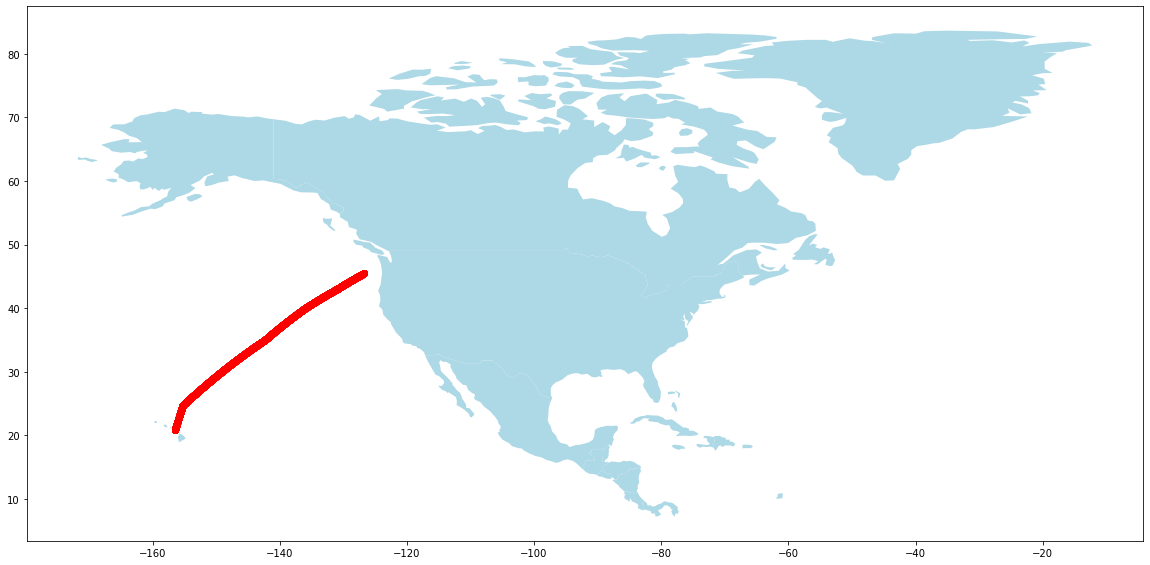

In [19]:
# Plot world map
axis = world_data[world_data.continent == 'North America'].plot(color = 'lightblue')
gdf_flight.plot(ax = axis, color = 'red')

fig = plt.gcf()
fig.set_size_inches(20,18)
plt.show()

In [ ]:
# Plot world map
axis = world_data.plot(color = 'lightblue')
gdf_time.plot(ax = axis, color = 'red')

fig = plt.gcf()
fig.set_size_inches(20,18)
plt.show()